In [2]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
import os
import warnings
import sys
warnings.filterwarnings("ignore")
sns.set_palette("colorblind")
fontsize = 20

In [3]:
perf_summary = pd.read_parquet("../files/multiclients_perf_summary.parquet")
exp_summary = pd.read_parquet("../files/multiclients_exp_summary.parquet").reset_index()
energy_summary = pd.read_parquet("../files/multiclients_energy_summary.parquet")

In [4]:
def get_strategy_perf(strategy_name, dataframe):
    strategy_res = dataframe[dataframe["strategy"] == strategy_name]
    strategy_res['total_Wh'] = strategy_res['total_kWh'].apply(lambda x: x*1000)
    return strategy_res

In [5]:
fedadam = get_strategy_perf("fedadam", perf_summary)
fedconstraints = get_strategy_perf("fedconstraints", perf_summary)

In [6]:
energygb = energy_summary.groupby(['strategy', 'role', 'hostname','nb_clients']).apply(lambda x: x)

#### Global Graph

In [7]:
path_to_save = "/Users/Slaton/Documents/grenoble-code/fl-flower/jetson-tl/graphs"

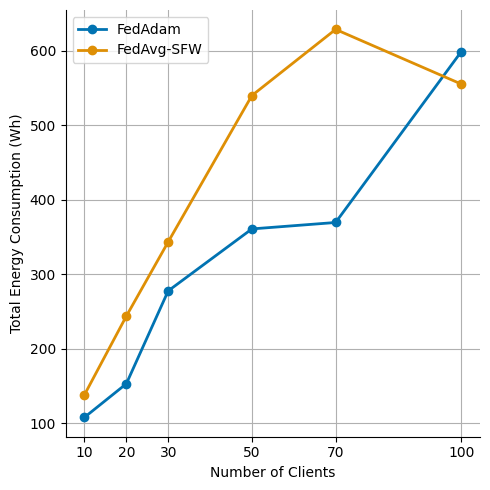

In [8]:
fig,axs = plt.subplots(1,1,figsize=(5, 5))
axs.plot(fedadam['nb_clients'], fedadam['total_Wh'], marker='o', label='FedAdam', linewidth=2)
axs.plot(fedconstraints['nb_clients'], fedconstraints['total_Wh'], marker='o', label='FedAvg-SFW',linewidth=2)
axs.set_xlabel('Number of Clients')
axs.set_ylabel('Total Energy Consumption (Wh)')
axs.grid(True)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_xticks(fedadam['nb_clients'])
axs.legend()
plt.tight_layout()
plt.savefig(os.path.join(path_to_save, "multiclients_energy_consumption.pdf"), format='pdf', bbox_inches='tight', dpi=300)


Rectangle(xy=(-0.4, 0), width=0.4, height=3203.94, angle=0)
Rectangle(xy=(0.6, 0), width=0.4, height=5317.56, angle=0)
Rectangle(xy=(1.6, 0), width=0.4, height=10211, angle=0)
Rectangle(xy=(2.6, 0), width=0.4, height=14241.8, angle=0)
Rectangle(xy=(3.6, 0), width=0.4, height=14909.2, angle=0)
Rectangle(xy=(4.6, 0), width=0.4, height=24673.7, angle=0)
Rectangle(xy=(5.55112e-17, 0), width=0.4, height=4115.84, angle=0)
Rectangle(xy=(1, 0), width=0.4, height=8354.38, angle=0)
Rectangle(xy=(2, 0), width=0.4, height=12595.3, angle=0)
Rectangle(xy=(3, 0), width=0.4, height=21096.6, angle=0)
Rectangle(xy=(4, 0), width=0.4, height=25261.1, angle=0)
Rectangle(xy=(5, 0), width=0.4, height=22825.6, angle=0)


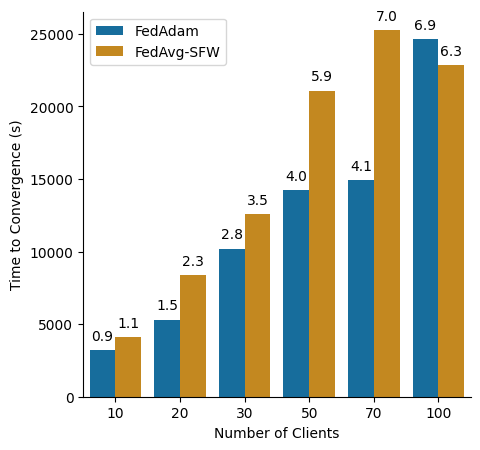

In [9]:
time_starts = exp_summary[['strategy', 'nb_clients','timestamps.start_experiment']] 
time_ends = perf_summary[['strategy', 'nb_clients','filtered_acc_distributed_time']]
times_pd = pd.merge(time_starts, time_ends, on=['strategy', 'nb_clients'])
times_pd['exp_time'] = (times_pd['filtered_acc_distributed_time'] - times_pd['timestamps.start_experiment']).dt.total_seconds()

fig,axs=plt.subplots(1,1,figsize=(5, 5))
bar_plot = sns.barplot(x='nb_clients', y='exp_time', hue='strategy', data=times_pd, ax=axs)
axs.set_xlabel('Number of Clients')
axs.set_ylabel('Time to Convergence (s)')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
# Get the current legend
legend = axs.get_legend()
# Rename the legend text
legend.set_title(None)
new_labels = ['FedAdam', 'FedAvg-SFW']
for t, l in zip(legend.texts, new_labels): t.set_text(l)

def add_value_labels(bar_plot):
    for p in bar_plot.patches:
        if p.get_x() == 0:
            continue
        print(p)
        bar_plot.annotate(format(p.get_height()/3600, '.1f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 10), 
                          textcoords = 'offset points')

# Add value labels
add_value_labels(bar_plot)

plt.savefig(os.path.join(path_to_save, "multiclients_time_to_convergence.pdf"), format='pdf', bbox_inches='tight', dpi=300)


#### Result Graph

In [10]:
path_to_read = "/Users/Slaton/Documents/grenoble-code/fl-flower/jetson-tl/analysis/files"
clients = [10,20,30,50,70,100]
#path_list = [os.path.join(path_to_read, f'{nbclients}clients') for nbclients in clients]
adam = []
constraints = []
for client in clients:
    path_client = os.path.join(path_to_read, f'{client}clients')
    
    filtered_adam = perf_summary['strategy'] == 'fedadam'
    filtered_constraints = perf_summary['strategy'] == 'fedconstraints'
    filtered_clients = perf_summary['nb_clients'] == client
    
    get_adam = perf_summary[filtered_adam & filtered_clients]['filtered_acc_distributed_round'].item()
    get_cosntraints = perf_summary[filtered_constraints & filtered_clients]['filtered_acc_distributed_round'].item()
    
    adam_csv = pd.read_csv(os.path.join(path_client, 'fedadam.csv'))
    adam_csv = adam_csv[adam_csv['server_round'] <= get_adam]

    constraints_csv = pd.read_csv(os.path.join(path_client, 'fedconstraints.csv'))
    constraints_csv = constraints_csv[constraints_csv['server_round'] <= get_cosntraints]
    
    adam.append(adam_csv)
    constraints.append(constraints_csv)


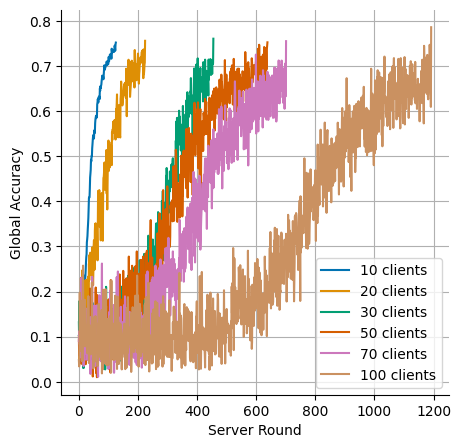

In [18]:
fig,axs = plt.subplots(1,1,figsize=(5, 5))
labels = ['10 clients', '20 clients', '30 clients', '50 clients', '70 clients', '100 clients']
for index,label in enumerate(labels):
    axs.plot(adam[index]['acc_distributed'].rolling(window=1).mean().values, label=label)
axs.set_xlabel('Server Round')
axs.set_ylabel('Global Accuracy')
axs.grid(True)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.legend()
plt.savefig(os.path.join(path_to_save, "multiclients_fedadam_accuracy.pdf"), format='pdf', bbox_inches='tight', dpi=300)

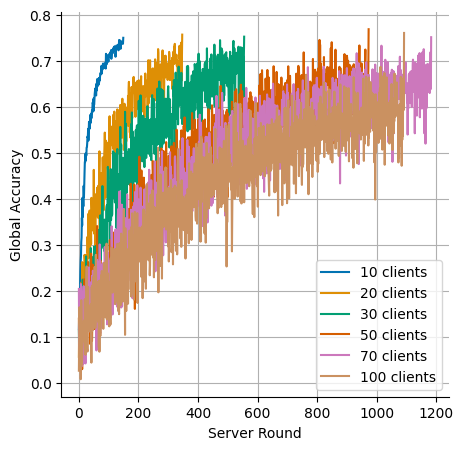

In [19]:
fig,axs = plt.subplots(1,1,figsize=(5, 5))
labels = ['10 clients', '20 clients', '30 clients', '50 clients', '70 clients', '100 clients']
for index,label in enumerate(labels):
    axs.plot(constraints[index]['acc_distributed'].rolling(window=1).mean().values, label=label)
axs.set_xlabel('Server Round')
axs.set_ylabel('Global Accuracy')
axs.grid(True)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.legend()
plt.savefig(os.path.join(path_to_save, "multiclients_fedconstraints_accuracy.pdf"), format='pdf', bbox_inches='tight', dpi=300)

In [14]:
constraints[4]['acc_distributed'].rolling(window=1).mean().values

array([0.20396601, 0.08757062, 0.05128205, ..., 0.71893491, 0.63896848,
       0.75141243])